In [71]:
import pandas as pd
import numpy as np
import scipy as sp
import requests
import json
import folium
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="orlando")
#!pip3 install requests

# Getting the covid-19 data for Orange County
We begin by reading in the json file and converting it into a pandas dataframe.  The following json file is a geojson file.  We will use this for both determining the number of cases of covid-19 and for finding boundaries of zipcodes.

In [72]:
data = requests.get("https://opendata.arcgis.com/datasets/09ec2e757f91411b8e12445805cf2809_0.geojson?where=COUNTYNAME%20%3D%20'Orange'")
data = data.json()

**We want to see what keys we have and we determine that we need 'features'.  **

In [73]:
with open('data.json', 'w')as outfile:
    json.dump(data, outfile)

In [74]:
print (data.keys())
print(type(data['features']))

dict_keys(['type', 'name', 'crs', 'features'])
<class 'list'>


**We see that we get  a list of dicts so we will have have to wrangle our data in order to get it into a data frame.**

In [75]:
type(data['features'][0]['properties'])
data['features'][0]['geometry']


{'type': 'MultiPolygon',
 'coordinates': [[[[-81.58507389999994, 28.708257],
    [-81.58504169999998, 28.70797710000005],
    [-81.58363889999998, 28.707979400000056],
    [-81.58357989999996, 28.707937100000038],
    [-81.58264919999993, 28.706713800000045],
    [-81.583022, 28.70649030000004],
    [-81.58323659999996, 28.706210300000066],
    [-81.58344579999994, 28.706095100000027],
    [-81.58368719999999, 28.706003300000077],
    [-81.58405729999998, 28.70593740000004],
    [-81.58482439999995, 28.70597040000007],
    [-81.58484589999995, 28.70526220000005],
    [-81.58408119999996, 28.705134200000032],
    [-81.58387579999999, 28.705127100000027],
    [-81.58381009999994, 28.704163600000072],
    [-81.58380469999997, 28.703923700000075],
    [-81.58360989999994, 28.70392430000004],
    [-81.58342169999997, 28.70392380000004],
    [-81.583368, 28.703923700000075],
    [-81.58305649999994, 28.703922800000043],
    [-81.58086189999995, 28.703916700000036],
    [-81.58049649999998, 2

In [76]:
columns = data['features'][0]['properties'].keys()
covid_df = pd.DataFrame(columns = columns)
covid_df.shape

(0, 15)

**each item in the list below is a dict of dicts.  We have to wrangle the required data from it**

In [77]:
i = 0
for item in data['features']:
    new_dict = item['properties']
    new_dict = pd.DataFrame(new_dict, index=[i])
    covid_df = pd.concat([covid_df, new_dict])
    i=i+1
covid_df.shape

(47, 15)

In [78]:
covid_df.head()

,OBJECTID,ZIP,OBJECTID_1,DEPCODE,COUNTYNAME,FieldMatch,POName,Places,OBJECTID_12,ZIPX,c_places,Cases_1,LabelY,SHAPE_Length,SHAPE_Area
0,355,32703,683,48,Orange,Orange-32703,Apopka,"Apopka, Ocoee, Clarcona, Forest City, Lockhart...",705,Orange-32703,Apopka,150,150,0.736955,0.009063
1,359,32709,688,48,Orange,Orange-32709,Christmas,"Bithlo, Christmas, Wedgefield",706,Orange-32709,Christmas,7,7,1.494471,0.035650
2,360,32712,692,48,Orange,Orange-32712,Apopka,"Apopka, Mount Plymouth, Wekiwa Springs, Zellwood",707,Orange-32712,Apopka,148,148,0.659092,0.015048
3,376,32751,717,48,Orange,Orange-32751,Maitland,"Altamonte Springs, Eatonville, Maitland, Casse...",708,Orange-32751,Maitland,35,35,0.241671,0.001487
4,381,32757,723,48,Orange,Orange-32757,Mount Dora,"Mount Dora, Tangerine, Zellwood",709,Orange-32757,,0,0,0.566806,0.011716


**I now get the zipcode along with the number of cases.  I convert the number of cases to an int to be used for our choropleth map later**

In [79]:
covid_df = covid_df[['ZIP', 'POName', "Cases_1"]]
covid_df.columns = ['zipcode', 'related city', 'cases']
covid_df['cases'].replace(to_replace="<5", value=5, inplace=True)
covid_df['cases'] = covid_df['cases'].astype(int)
covid_df.head()

,zipcode,related city,cases
0,32703,Apopka,150
1,32709,Christmas,7
2,32712,Apopka,148
3,32751,Maitland,35
4,32757,Mount Dora,0


**While the data retrieved above does give the boundary coordinates of each zip code, we need a specific coordinate for each zipcode to use with four square.  We use geocode to convert zipcodes to latitude, longitude**

In [80]:
def getLatLongFromZip(zipcodes): # a panda series of zipcodes should be supplied
       
    coordinates = pd.DataFrame(columns=['Latitude', 'Longitude'])
    i=0
    for zipcode in zipcodes:
        
        while(True):# geopy times out sometimes so this will run until it geopy no longer times out
            try:
                location = geolocator.geocode(str(zipcode))
                zip_coord = {"Latitude": location.latitude, "Longitude": location.longitude}
                zip_coord = pd.DataFrame(zip_coord, index=[i])
                coordinates = pd.concat([coordinates, zip_coord])
                i=i+1
                break
            except:
                pass
    return coordinates
   

In [81]:
coordinates = getLatLongFromZip(covid_df['zipcode'])


In [82]:
coordinates.head()

,Latitude,Longitude
0,28.663529,-81.474428
1,28.564218,-81.065553
2,28.726430,-81.521900
3,28.628243,-81.354615
4,28.819383,-81.683776


In [83]:
covid_df['Latitude'] = coordinates.Latitude
covid_df['Longitude'] = coordinates.Longitude
covid_df.head()

,zipcode,related city,cases,Latitude,Longitude
0,32703,Apopka,150,28.663529,-81.474428
1,32709,Christmas,7,28.564218,-81.065553
2,32712,Apopka,148,28.726430,-81.521900
3,32751,Maitland,35,28.628243,-81.354615
4,32757,Mount Dora,0,28.819383,-81.683776


In [84]:
# create map
import matplotlib.cm as cm
import matplotlib.colors as colors

map = folium.Map(location=[28.4845, -81.2519], zoom_start=10)

for lat, lon, poi in zip(covid_df['Latitude'], covid_df['Longitude'], covid_df['zipcode']):
    label = folium.Popup(str(poi),parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7).add_to(map)
       
map

**Some zipcodes did not convert correctly as can be seen above. I found it easier to manually fix them here**

In [85]:
def replaceLatLong(changes, df):
    for item in changes:
        index = df[df['zipcode']==item[0]].index.values
        df.at[index, 'Latitude'] = item[1]
        df.at[index,'Longitude'] = item[2]
    return df

In [86]:

changes = [['32805', '28.5346', '-81.4004'],
          ['32839', '28.4889', '-81.4114'],
          ['32816', '28.6013', '-81.2009'],
          ['32825', '28.5417', '-81.2409'],
          ['34734', '28.5391', '-81.5185'],
          ['32820', '28.5808', '-81.1306'],
          ['32776', '28.132', '-81.5048'],
          ['32757', '28.7520', '-81.6364'],
          ['34734', '28.5391', '-81.5185'],
          ['34760', '28.5575', '-81.6282'],
          ['32810', '28.6235', '-81.4247'],
          ['32814', '28.5729', '-81.3207'],
          ['32812', '28.4833', '-81.3234'],
          ['32709', '28.5381', '-81.0092']]
covid_df = replaceLatLong(changes, covid_df)


In [87]:
map = folium.Map(location=[28.4845, -81.2519], zoom_start=10)

for lat, lon, poi in zip(covid_df['Latitude'], covid_df['Longitude'], covid_df['zipcode']):
    label = folium.Popup(str(poi),parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7).add_to(map)
       
map

**We now use the Foursquare API to find features for each zipcode**

In [88]:
covid_df.head()

,zipcode,related city,cases,Latitude,Longitude
0,32703,Apopka,150,28.6635,-81.4744
1,32709,Christmas,7,28.5381,-81.0092
2,32712,Apopka,148,28.7264,-81.5219
3,32751,Maitland,35,28.6282,-81.3546
4,32757,Mount Dora,0,28.7520,-81.6364


In [89]:
CLIENT_ID = 'R5KOR3AWIJIG5OSFBPTN40EYQWJ3Z2YU2CCPTPXGNF0UWVXO'# your Foursquare ID
CLIENT_SECRET = 'TEVQLN53WG5XPUNNPSXIUHGVELTOC22GEW1KJWOBIQBAC2KJ' # your Foursquare Secret
VERSION = '202006017' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: R5KOR3AWIJIG5OSFBPTN40EYQWJ3Z2YU2CCPTPXGNF0UWVXO
CLIENT_SECRET:TEVQLN53WG5XPUNNPSXIUHGVELTOC22GEW1KJWOBIQBAC2KJ


**We create a function to get nearby venues of each zipcode**

In [90]:
def getNearbyVenues(zipcodes, latitudes, longitudes,radius=3000):
    
    LIMIT = 100
    venues_list=[]
    no_venues_for_zipcode_list=[]
    for zipcode, lat, lng in zip(zipcodes, latitudes, longitudes):
        # create the API request URL
        
        while True: # sometimes a key error happens for no reason
            try:
                url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
                    CLIENT_ID, 
                    CLIENT_SECRET, 
                    VERSION, 
                    lat, 
                    lng, 
                    radius, 
                    LIMIT)

                # make the GET request
                results = requests.get(url).json()["response"]['groups'][0]['items']
                if not results:
                    print (zipcode)
                    no_venues_for_zipcode_list.append(zipcode)
                # return only relevant information for each nearby venue
                venues_list.append([(
                    zipcode, 
                    lat, 
                    lng, 
                    v['venue']['name'], 
                    v['venue']['location']['lat'], 
                    v['venue']['location']['lng'],  
                    v['venue']['categories'][0]['name']) for v in results])
                break
            except:
                print("Trying again on zipcode: ", zipcode)
                pass
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['zipcode', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues, no_venues_for_zipcode_list)

In [91]:
orange_venues, missing_venues_list = getNearbyVenues(zipcodes=covid_df.zipcode,
                            latitudes=covid_df.Latitude,
                            longitudes=covid_df.Longitude)
orange_venues.shape

Trying again on zipcode:  32805
Trying again on zipcode:  32826


(3369, 7)

In [92]:
orange_venues

,zipcode,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,32703,28.6635,-81.4744,Wawa,28.653959,-81.468428,Convenience Store
1,32703,28.6635,-81.4744,Hobby Lobby,28.671436,-81.466178,Fabric Shop
2,32703,28.6635,-81.4744,Garibaldi Mexican Restaurant,28.675037,-81.468695,Mexican Restaurant
3,32703,28.6635,-81.4744,RaceTrac,28.672211,-81.478443,Gas Station
4,32703,28.6635,-81.4744,ALDI,28.672092,-81.479684,Grocery Store
...,...,...,...,...,...,...,...
3364,34787,28.5516,-81.5961,Seacoast Bank,28.551514,-81.578764,Bank
3365,34787,28.5516,-81.5961,Quercus Quesinberry Oak,28.559243,-81.612346,Park
3366,34787,28.5516,-81.5961,West Orange Bike Trail,28.559047,-81.613692,Trail
3367,34787,28.5516,-81.5961,Love At First Sip,28.550712,-81.570072,Bubble Tea Shop


In [93]:
orange_venues['zipcode'].unique()

array(['32703', '32709', '32712', '32751', '32757', '32776', '32789',
       '32792', '32798', '32801', '32803', '32804', '32805', '32806',
       '32807', '32808', '32809', '32810', '32811', '32812', '32814',
       '32816', '32817', '32818', '32819', '32820', '32821', '32822',
       '32824', '32825', '32826', '32827', '32828', '32829', '32830',
       '32831', '32832', '32833', '32835', '32836', '32837', '32839',
       '34734', '34760', '34761', '34786', '34787'], dtype=object)

**Now we do one hot encoding so that we can run kmeans clustering**

In [94]:
orange_onehot = pd.get_dummies(orange_venues[['Venue Category']], prefix="", prefix_sep="")
orange_onehot['zipcode'] = orange_venues['zipcode']
fixed_columns = [orange_onehot.columns[-1]] + list(orange_onehot.columns[:-1])
orange_onehot = orange_onehot[fixed_columns]
orange_onehot

,zipcode,Accessories Store,Adult Boutique,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Volleyball Court,Warehouse Store,Water Park,Weight Loss Center,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,32703,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,32703,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,32703,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,32703,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,32703,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3364,34787,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3365,34787,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3366,34787,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3367,34787,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [95]:
a = orange_onehot.groupby('zipcode').sum().reset_index()
a

,zipcode,Accessories Store,Adult Boutique,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Volleyball Court,Warehouse Store,Water Park,Weight Loss Center,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,32703,0,0,1,0,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
1,32709,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,32712,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
3,32751,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
4,32757,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,32776,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,32789,0,0,0,0,0,0,5,1,0,...,0,0,0,0,0,0,0,0,1,0
7,32792,0,0,0,0,0,0,2,0,0,...,0,1,0,0,0,0,1,0,0,0
8,32798,0,0,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
9,32801,0,0,0,0,0,0,5,0,0,...,0,0,0,0,1,0,0,0,0,0


**We create a barchart to show the number of venues returned in each zipcode**

Text(0.5, 1.0, 'Number of Venues per Zipcode')

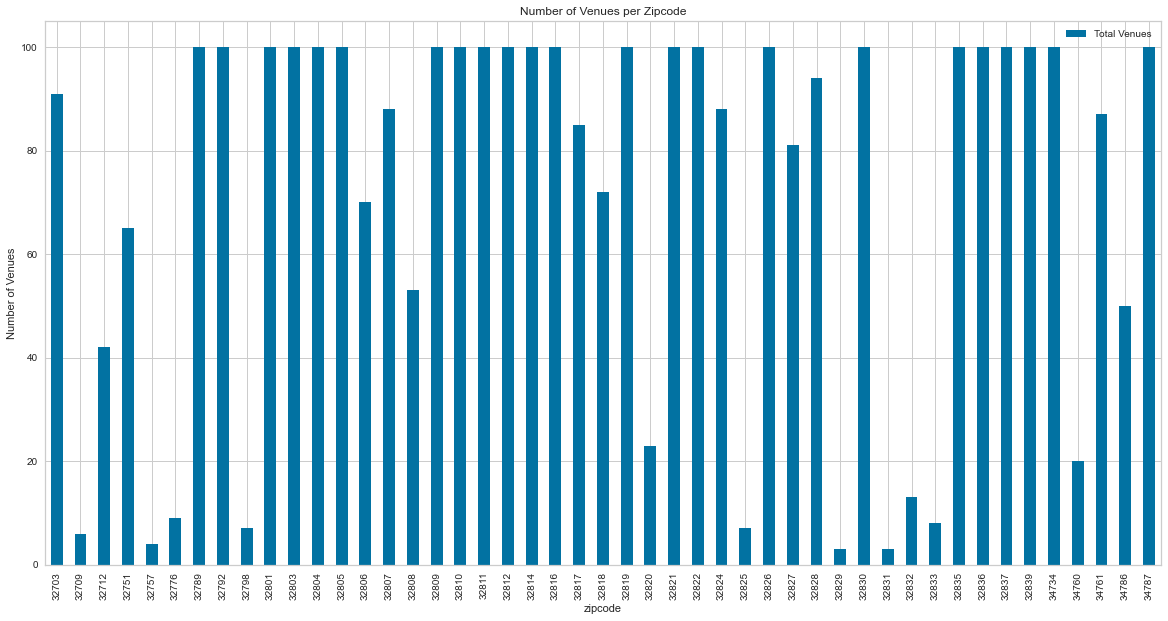

In [96]:
import matplotlib.pyplot as plt
orange_grouped = orange_onehot.groupby('zipcode').sum().reset_index()
# orange_grouped = orange_onehot.groupby('zipcode')
sum_of_venues = orange_grouped.drop(columns=['zipcode'])
sum_of_venues = sum_of_venues.sum(axis=1)
barchart = pd.DataFrame()
barchart['zipcode'] = orange_grouped['zipcode']
# barchart['total venues'] = sum_of_venues
barchart['Total Venues'] = sum_of_venues
barchart.set_index('zipcode', inplace=True)
ax = barchart.plot.bar(figsize=(20,10))
plt.ylabel('Number of Venues')
plt.title('Number of Venues per Zipcode')

In [97]:
orange_grouped.describe()

,Accessories Store,Adult Boutique,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,...,Volleyball Court,Warehouse Store,Water Park,Weight Loss Center,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
count,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.00000,47.000000,...,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000
mean,0.106383,0.042553,0.085106,0.042553,0.085106,0.042553,1.978723,0.021277,0.12766,0.042553,...,0.021277,0.170213,0.063830,0.042553,0.191489,0.085106,0.276596,0.085106,0.170213,0.042553
std,0.429056,0.204030,0.350762,0.291730,0.583460,0.291730,1.823629,0.145865,0.87519,0.204030,...,0.145865,0.480903,0.323315,0.204030,0.537235,0.282057,0.649486,0.350762,0.433346,0.204030
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.000000,1.000000,2.000000,2.000000,4.000000,2.000000,5.000000,1.000000,6.00000,1.000000,...,1.000000,2.000000,2.000000,1.000000,3.000000,1.000000,3.000000,2.000000,2.000000,1.000000


**I now run k means clustering to cluster the zipcodes**

In [98]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [99]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['zipcode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['zipcode'] = orange_grouped['zipcode']

for ind in np.arange(orange_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(orange_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,zipcode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,32703,Pizza Place,Grocery Store,Discount Store,Convenience Store,Mexican Restaurant,American Restaurant,Fast Food Restaurant,Sushi Restaurant,Gas Station,Rental Car Location
1,32709,Monument / Landmark,Sculpture Garden,Campground,Convenience Store,Gas Station,Grocery Store,Farm,Farmers Market,Fast Food Restaurant,Field
2,32712,Baseball Field,Golf Course,American Restaurant,Pizza Place,Discount Store,Salon / Barbershop,Park,Recreation Center,Fast Food Restaurant,Martial Arts Dojo
3,32751,Pizza Place,Convenience Store,Park,Grocery Store,Pharmacy,Thai Restaurant,Smoke Shop,Chinese Restaurant,Sandwich Place,Steakhouse
4,32757,Gym,Post Office,Park,Italian Restaurant,Fabric Shop,Farm,Farmers Market,Fast Food Restaurant,Field,Financial or Legal Service
5,32776,Pizza Place,Golf Course,Pool,Gym / Fitness Center,Trail,American Restaurant,Field,Exhibit,Fabric Shop,Farm
6,32789,Grocery Store,American Restaurant,Italian Restaurant,Pet Store,Mexican Restaurant,Pharmacy,Steakhouse,Pizza Place,Café,Sandwich Place
7,32792,Grocery Store,Gym,Pharmacy,Restaurant,Sandwich Place,Video Store,Gym / Fitness Center,Pizza Place,Cajun / Creole Restaurant,Ice Cream Shop
8,32798,American Restaurant,Post Office,Airport,Soccer Field,Golf Course,Salon / Barbershop,Fish Market,Farm,Farmers Market,Fast Food Restaurant
9,32801,Bar,Park,American Restaurant,Coffee Shop,Vietnamese Restaurant,Pizza Place,Cocktail Bar,Grocery Store,Hotel,Mexican Restaurant


In [100]:
grouped_clusters = orange_grouped.drop('zipcode', 1)
grouped_clusters.head()

,Accessories Store,Adult Boutique,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,...,Volleyball Court,Warehouse Store,Water Park,Weight Loss Center,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,0,0,1,0,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


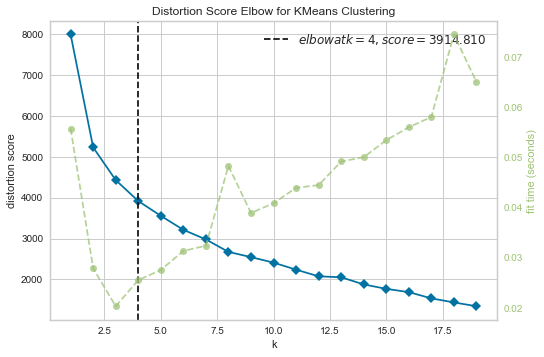

In [101]:
#!pip3 install yellowbrick #uncomment if you have not installed yellowbric
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
model = KMeans()
visualizer = KElbowVisualizer(model, k = (1,20))
visualizer.fit(grouped_clusters)
visualizer.show()

**Based on the elbow method above, we should use 5 clusters**

In [102]:
from sklearn.preprocessing import StandardScaler
kclusters = 5
kmeans = KMeans(n_clusters=kclusters, init='random', n_init=500).fit(grouped_clusters)
labels = kmeans.labels_
labels
kmeans.cluster_centers_

array([[ 0.00000000e+00,  6.93889390e-18,  1.38777878e-17, ...,
         1.38777878e-17,  3.33333333e-01,  6.93889390e-18],
       [ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       [ 1.53846154e-01,  1.53846154e-01,  1.38777878e-17, ...,
         2.30769231e-01,  3.07692308e-01,  7.69230769e-02],
       [ 1.42857143e-01,  1.38777878e-17,  2.14285714e-01, ...,
         2.77555756e-17,  7.14285714e-02,  1.38777878e-17],
       [-2.77555756e-17,  1.38777878e-17,  6.25000000e-02, ...,
         6.25000000e-02,  6.25000000e-02,  1.38777878e-17]])

In [103]:
labels

array([4, 3, 3, 4, 3, 3, 2, 4, 3, 2, 2, 2, 2, 2, 4, 4, 2, 4, 2, 4, 2, 2,
       4, 4, 0, 3, 1, 4, 4, 3, 2, 3, 4, 3, 0, 3, 3, 3, 4, 0, 2, 2, 4, 3,
       4, 3, 4], dtype=int32)

In [104]:
try:
    neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
except:
    pass
    
covid_merged = covid_df
covid_merged = covid_merged.join(neighborhoods_venues_sorted.set_index('zipcode'), on='zipcode')

covid_merged = covid_merged.dropna() 
covid_merged['Cluster Labels'] = covid_merged['Cluster Labels'].astype(int)
covid_merged.head()

,zipcode,related city,cases,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,32703,Apopka,150,28.6635,-81.4744,4,Pizza Place,Grocery Store,Discount Store,Convenience Store,Mexican Restaurant,American Restaurant,Fast Food Restaurant,Sushi Restaurant,Gas Station,Rental Car Location
1,32709,Christmas,7,28.5381,-81.0092,3,Monument / Landmark,Sculpture Garden,Campground,Convenience Store,Gas Station,Grocery Store,Farm,Farmers Market,Fast Food Restaurant,Field
2,32712,Apopka,148,28.7264,-81.5219,3,Baseball Field,Golf Course,American Restaurant,Pizza Place,Discount Store,Salon / Barbershop,Park,Recreation Center,Fast Food Restaurant,Martial Arts Dojo
3,32751,Maitland,35,28.6282,-81.3546,4,Pizza Place,Convenience Store,Park,Grocery Store,Pharmacy,Thai Restaurant,Smoke Shop,Chinese Restaurant,Sandwich Place,Steakhouse
4,32757,Mount Dora,0,28.7520,-81.6364,3,Gym,Post Office,Park,Italian Restaurant,Fabric Shop,Farm,Farmers Market,Fast Food Restaurant,Field,Financial or Legal Service


**Its starting to look like we have two major clusters**

**Now I visualize the clusters**

In [105]:
# create map
import matplotlib.cm as cm
import matplotlib.colors as colors



orange_map = folium.Map(location=[28.4845, -81.2519], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(covid_merged['Latitude'], covid_merged['Longitude'], covid_merged['zipcode'], covid_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(orange_map)
       
orange_map

**As we can see almost all of our zipcodes have been clustered into one giant cluster. However, I will proceed to examine what the clusters have in common**

In [106]:
covid_merged.loc[covid_merged['Cluster Labels'] == 0, covid_merged.columns[[0]+list(range(5, covid_merged.shape[1]))]].head()

,zipcode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
24,32819,0,Theme Park Ride / Attraction,Coffee Shop,Bar,Gift Shop,Mexican Restaurant,Theme Park,American Restaurant,Burger Joint,Souvenir Shop,Music Venue
34,32830,0,Theme Park Ride / Attraction,Resort,Gift Shop,Lounge,Hotel,Hotel Bar,American Restaurant,Train Station,Buffet,Golf Course
39,32836,0,Theme Park Ride / Attraction,Gift Shop,Sandwich Place,American Restaurant,Ice Cream Shop,Park,Gym,Public Bathroom,Coffee Shop,Resort


In [107]:
cluster_0=covid_merged.loc[covid_merged['Cluster Labels'] == 0, covid_merged.columns[[0]+list(range(5, covid_merged.shape[1]))]]
cluster_0=cluster_0.drop(columns=['zipcode', 'Cluster Labels'])
cluster_0 = cluster_0.stack().value_counts()
cluster_0 = cluster_0.head(5)
cluster_0

Theme Park Ride / Attraction    3
Gift Shop                       3
American Restaurant             3
Resort                          2
Coffee Shop                     2
dtype: int64

In [108]:
covid_merged.loc[covid_merged['Cluster Labels'] == 1, covid_merged.columns[[0]+list(range(5, covid_merged.shape[1]))]].head()

,zipcode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
26,32821,1,Hotel,Theme Park Ride / Attraction,Aquarium,American Restaurant,Theme Park,Pharmacy,Stadium,Italian Restaurant,Steakhouse,Seafood Restaurant


In [109]:
cluster_1=covid_merged.loc[covid_merged['Cluster Labels'] == 1, covid_merged.columns[[0]+list(range(5, covid_merged.shape[1]))]]
cluster_1=cluster_1.drop(columns=['zipcode', 'Cluster Labels'])
cluster_1 = cluster_1.stack().value_counts()
cluster_1 = cluster_1.head(5)
cluster_1

Aquarium               1
Pharmacy               1
Italian Restaurant     1
Stadium                1
American Restaurant    1
dtype: int64

In [110]:
covid_merged.loc[covid_merged['Cluster Labels'] == 2, covid_merged.columns[[0]+list(range(5, covid_merged.shape[1]))]].head()

,zipcode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,32789,2,Grocery Store,American Restaurant,Italian Restaurant,Pet Store,Mexican Restaurant,Pharmacy,Steakhouse,Pizza Place,Café,Sandwich Place
9,32801,2,Bar,Park,American Restaurant,Coffee Shop,Vietnamese Restaurant,Pizza Place,Cocktail Bar,Grocery Store,Hotel,Mexican Restaurant
10,32803,2,Vietnamese Restaurant,Coffee Shop,Park,Asian Restaurant,Beer Bar,Brewery,American Restaurant,Bar,Pizza Place,Mexican Restaurant
11,32804,2,American Restaurant,Bar,Coffee Shop,Park,Wine Bar,Pet Store,Theater,Italian Restaurant,Brewery,Grocery Store
12,32805,2,Bar,Hotel,Gay Bar,American Restaurant,Coffee Shop,Fried Chicken Joint,Cocktail Bar,Spa,Bed & Breakfast,Theater


In [111]:
cluster_2=covid_merged.loc[covid_merged['Cluster Labels'] == 2, covid_merged.columns[[0]+list(range(5, covid_merged.shape[1]))]]
cluster_2=cluster_2.drop(columns=['zipcode', 'Cluster Labels'])
cluster_2 = cluster_2.stack().value_counts()
cluster_2 = cluster_2.head(5)
cluster_2

Coffee Shop            9
American Restaurant    9
Mexican Restaurant     8
Pizza Place            7
Park                   6
dtype: int64

In [112]:
covid_merged.loc[covid_merged['Cluster Labels'] == 3, covid_merged.columns[[0]+list(range(5, covid_merged.shape[1]))]].head()

,zipcode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,32709,3,Monument / Landmark,Sculpture Garden,Campground,Convenience Store,Gas Station,Grocery Store,Farm,Farmers Market,Fast Food Restaurant,Field
2,32712,3,Baseball Field,Golf Course,American Restaurant,Pizza Place,Discount Store,Salon / Barbershop,Park,Recreation Center,Fast Food Restaurant,Martial Arts Dojo
4,32757,3,Gym,Post Office,Park,Italian Restaurant,Fabric Shop,Farm,Farmers Market,Fast Food Restaurant,Field,Financial or Legal Service
5,32776,3,Pizza Place,Golf Course,Pool,Gym / Fitness Center,Trail,American Restaurant,Field,Exhibit,Fabric Shop,Farm
8,32798,3,American Restaurant,Post Office,Airport,Soccer Field,Golf Course,Salon / Barbershop,Fish Market,Farm,Farmers Market,Fast Food Restaurant


In [113]:
cluster_3=covid_merged.loc[covid_merged['Cluster Labels'] == 3, covid_merged.columns[[0]+list(range(5, covid_merged.shape[1]))]]
cluster_3=cluster_3.drop(columns=['zipcode', 'Cluster Labels'])
cluster_3 = cluster_3.stack().value_counts()
cluster_3 = cluster_3.head(5)
cluster_3

Farm                    10
Fast Food Restaurant     9
Farmers Market           7
Golf Course              6
Field                    5
dtype: int64

In [114]:
covid_merged.loc[covid_merged['Cluster Labels'] == 4, covid_merged.columns[[0]+list(range(5, covid_merged.shape[1]))]].head()

,zipcode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,32703,4,Pizza Place,Grocery Store,Discount Store,Convenience Store,Mexican Restaurant,American Restaurant,Fast Food Restaurant,Sushi Restaurant,Gas Station,Rental Car Location
3,32751,4,Pizza Place,Convenience Store,Park,Grocery Store,Pharmacy,Thai Restaurant,Smoke Shop,Chinese Restaurant,Sandwich Place,Steakhouse
7,32792,4,Grocery Store,Gym,Pharmacy,Restaurant,Sandwich Place,Video Store,Gym / Fitness Center,Pizza Place,Cajun / Creole Restaurant,Ice Cream Shop
14,32807,4,Convenience Store,Cuban Restaurant,Grocery Store,Discount Store,Sandwich Place,Pizza Place,Donut Shop,Rental Car Location,Gas Station,Electronics Store
15,32808,4,Convenience Store,Fast Food Restaurant,Park,Sandwich Place,Discount Store,Pharmacy,Grocery Store,Lake,Pool,Big Box Store


In [115]:
cluster_4=covid_merged.loc[covid_merged['Cluster Labels'] == 4, covid_merged.columns[[0]+list(range(5, covid_merged.shape[1]))]]
cluster_4=cluster_4.drop(columns=['zipcode', 'Cluster Labels'])
cluster_4 = cluster_4.stack().value_counts()
cluster_4 = cluster_4.head(5)
cluster_4

Pizza Place             15
Grocery Store           15
Convenience Store       13
Sandwich Place          12
Fast Food Restaurant    11
dtype: int64

**Earlier we got some data that included the boundaries of our zipcodes.  We will use it to make our choropleth map of covid-19 cases**

In [123]:
# covid_merged['cases'] = pd.to_numeric(covid_merged['cases'])
covid_df['cases'] = covid_df['cases'].astype(int)


In [124]:
len(data['features'])

47

In [118]:
covid_df.shape

(47, 5)

In [119]:

import folium
folium.Choropleth(geo_data=data,
                      data=covid_df,
                     columns=['zipcode', 'cases'],
                     fill_color='YlOrRd',
                      key_on="feature.properties.ZIP",
                     fill_opacity=0.7,
                     line_opacity=0.2,
                     legend_name='Covid Cases in Orange County by Zipcode').add_to(orange_map)

folium.LayerControl().add_to(orange_map)


In [120]:
markers_colors = []
for lat, lon, poi, cluster in zip(covid_merged['Latitude'], covid_merged['Longitude'], covid_merged['zipcode'], covid_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(orange_map)
       
orange_map


**To determine how many cases are in each cluster, I create bins and count the number of cases per cluster**

In [157]:
clusters = [0,1,2,3,4]
cases_per_cluster_df = pd.DataFrame(
    columns=['very low', 'low', 'medium low', 'medium high', 'high', 'very high'])
for label in clusters:
    cluster = covid_merged.loc[covid_merged['Cluster Labels'] == label]
    series = [0, 35, 70, 105, 140, 175, 210]
    count, bin_edge = np.histogram(cluster['cases'], bins = series)
    length = len(cases_per_cluster_df)
   
    cases_per_cluster_df.loc[length] = count
cases_per_cluster_df


,very low,low,medium low,medium high,high,very high
0,1,1,0,0,1,0
1,0,1,0,0,0,0
2,2,2,5,2,2,0
3,8,4,0,0,2,0
4,1,2,4,5,2,2


Text(0.5, 1.0, 'Number of zipcodes in each bin of covid-19 cases per cluster')

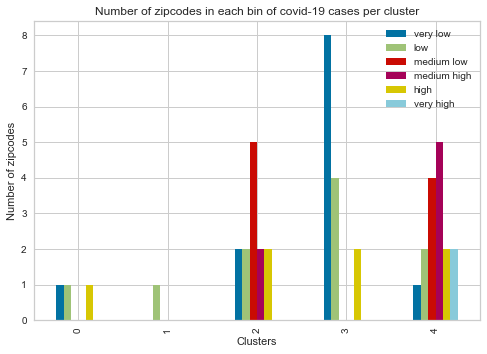

In [161]:
barchart = cases_per_cluster_df.plot.bar()
plt.ylabel('Number of zipcodes')
plt.xlabel('Clusters')
plt.title('Number of zipcodes in each bin of covid-19 cases per cluster')

In [167]:
cases_per_cluster_df.div(cases_per_cluster_df.sum(axis=1), axis=0)*100

,very low,low,medium low,medium high,high,very high
0,33.3333,33.3333,0,0,33.3333,0
1,0,100,0,0,0,0
2,15.3846,15.3846,38.4615,15.3846,15.3846,0
3,57.1429,28.5714,0,0,14.2857,0
4,6.25,12.5,25,31.25,12.5,12.5


,0,1,2,3,4,high,low,medium high,medium low,very high,very low
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
